# CNN Network

In [1]:
import os
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras import metrics
from keras.callbacks import EarlyStopping, History, ModelCheckpoint
from keras.layers.core import Flatten, Dense, Dropout, Reshape, Lambda
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import keras.backend as K
from IPython.display import Image
from IPython.display import display
from keras.utils import plot_model


Using TensorFlow backend.


### Disable Macos warnings

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### Helper functions

In [3]:
def get_num_files(path):
    """
    count number of files in this directory and all subfolders
    :param path:
    :return: integer total number of files in path
    """
    if not os.path.exists(path):
        return 0
    return sum([len(files) for r, d, files in os.walk(path)])

In [4]:
def get_num_subfolders(path):
    """
    get number of subfolders inside this path
    :param path:
    :return: integer number of subfolders inside this path
    """
    if not os.path.exists(path):
        return 0
    return sum([len(d) for r, d, files in os.walk(path)])

In [5]:
def create_img_generator():
    """
    define image generator that will be variations
    :return:
    """
    return ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )


In [6]:
def get_sample_spectrogram():
    """
    :return: list of spectrogram png files to display them
    """
    Images = [
        'data/t/normal/e00008.png',
        'data/v/normal/e00002.png',
        'data/t/abnormal/e00304.png',
        'data/v/abnormal/e00435.png'
    ]

    for imageName in Images:
        display(Image(filename=imageName))

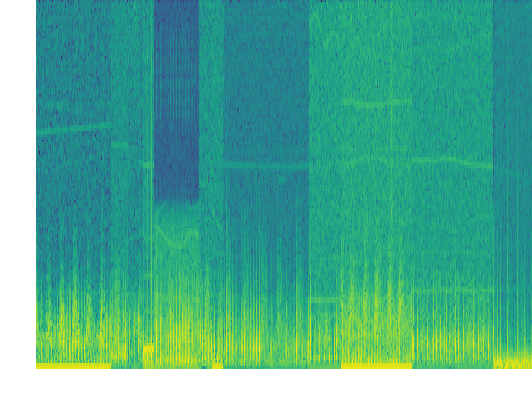

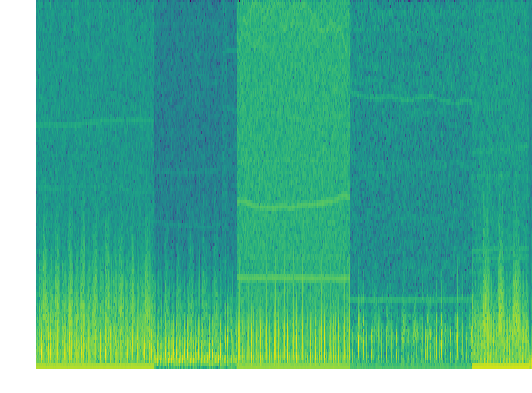

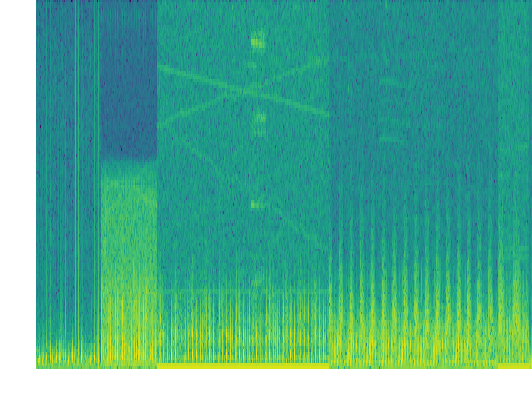

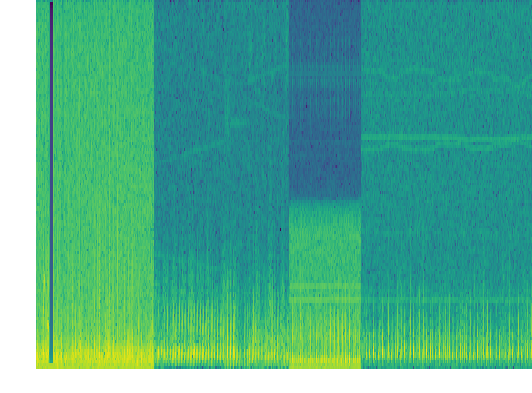

In [7]:
get_sample_spectrogram()

In [8]:
def visualize_samples(normal_train, normal_validation, abnormal_train, abnormal_validation):
    """

    :return: visualize graph for training / validation set with it's classes
    """
    n_groups = 2

    train_samples = (normal_train, normal_validation)
    validation_samples = (abnormal_train, abnormal_validation)

    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.4
    opacity = 0.7

    fig1 = plt.bar(index, train_samples, bar_width,
                   alpha=opacity,
                   color='r',
                   label='normal')

    fig2 = plt.bar(index + bar_width, validation_samples, bar_width,
                   alpha=opacity,
                   color='b',
                   label='abnormal')

    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.title('Samples and Classes')
    plt.xticks(index + bar_width, ('Train', 'Validation'))
    plt.legend()

    plt.tight_layout()
    plt.show()



In [9]:
# root path
train_dir = 'data/t'
validate_dir = 'data/v'
# training samples
num_train_samples = get_num_files(train_dir)
num_train_samples_normal = get_num_files(train_dir+str('/normal'))
num_train_samples_abnormal = get_num_files(train_dir+str('/abnormal'))
# number of classes
num_classes = get_num_subfolders(train_dir)
# validation samples
num_validate_samples = get_num_files(validate_dir)
num_validate_samples_normal = get_num_files(validate_dir+str('/normal'))
num_validate_samples_abnormal = get_num_files(validate_dir+str('/abnormal'))

In [10]:
print ('Total number of samples in training set : {}'.format((num_train_samples)))
print ('Number of samples in training(normal) set : {}'.format((num_train_samples_normal)))
print ('Number of samples in training(abnormal) set : {}'.format((num_train_samples_abnormal)))
print ('Number of classes : {}'.format((num_classes)))
print('Total number of validate samples : {}'.format(num_validate_samples))
print('Number of validate samples (nomral) : {}'.format(num_validate_samples_normal))
print('Number of validate samples (abnormal) : {}'.format(num_validate_samples_abnormal))

Total number of samples in training set : 3240
Number of samples in training(normal) set : 2575
Number of samples in training(abnormal) set : 665
Number of classes : 2
Total number of validate samples : 301
Number of validate samples (nomral) : 150
Number of validate samples (abnormal) : 151


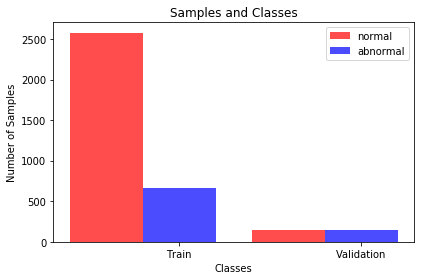

In [11]:
visualize_samples(
    normal_train=num_train_samples_normal, 
    normal_validation=num_validate_samples_normal,
    abnormal_train=num_train_samples_abnormal,
    abnormal_validation=num_validate_samples_abnormal
)

In [12]:
def precision(y_true, y_pred):
    """

    :param y_true:
    :param y_pred:
    :return: precision number
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """

    :param y_true:
    :param y_pred:
    :return:
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    """

    :param y_true:
    :param y_pred:
    :param beta:
    :return:
    """
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


In [13]:
def results(history):
    """

    :param history:
    :return: figure for accuracy and loss
    """
    # Accuracy
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()



In [14]:
# Main code
Image_width, Image_height = 300, 300
Training_Epochs = 5
Batch_Size = 32
Number_FC_Neurons = 1024

### Define pre-processing step

In [15]:
train_image_gen = create_img_generator()
test_image_gen  = create_img_generator() 

In [16]:
train_generator = train_image_gen.flow_from_directory(
    train_dir,
    target_size=(Image_width, Image_height),
    batch_size=Batch_Size,
    seed=42
)

Found 3240 images belonging to 2 classes.


In [17]:
validation_generator = test_image_gen.flow_from_directory(
    validate_dir,
    target_size=(Image_width, Image_height),
    batch_size=Batch_Size,
    seed=42
)

Found 301 images belonging to 2 classes.


### Simple CNN Model
### Define compile to minimize categorical loss, use ada delta optimized, and optimize to maximizing accuracy

In [18]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),
                 activation="relu",
                 input_shape=(Image_width,Image_height,3))
         )

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="softmax"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, fbeta_score])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 149, 149, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 73, 73, 64)        256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 341056)            0         
__________

### Plot the model

In [19]:
plot_model(model=model, to_file='simple-cnn.png', show_shapes=True, show_layer_names=True)

In [20]:
hist = model.fit_generator(
    train_generator,
    epochs=Training_Epochs,
    verbose=1,
    steps_per_epoch=num_train_samples // Batch_Size,
    validation_data=validation_generator,
    validation_steps= num_validate_samples // Batch_Size,
    class_weight='auto'
)

Epoch 1/5
101/101 [==============================] - 194s 2s/step - loss: 3.4673 - acc: 0.7791 - precision: 0.7791 - recall: 0.7791 - fbeta_score: 0.7791 - val_loss: 7.9595 - val_acc: 0.5035 - val_precision: 0.5035 - val_recall: 0.5035 - val_fbeta_score: 0.5035
Epoch 2/5
101/101 [==============================] - 185s 2s/step - loss: 3.2539 - acc: 0.7970 - precision: 0.7970 - recall: 0.7970 - fbeta_score: 0.7970 - val_loss: 8.2237 - val_acc: 0.4870 - val_precision: 0.4870 - val_recall: 0.4870 - val_fbeta_score: 0.4870
Epoch 3/5
101/101 [==============================] - 182s 2s/step - loss: 3.2688 - acc: 0.7961 - precision: 0.7961 - recall: 0.7961 - fbeta_score: 0.7961 - val_loss: 7.8065 - val_acc: 0.5130 - val_precision: 0.5130 - val_recall: 0.5130 - val_fbeta_score: 0.5130
Epoch 4/5
101/101 [==============================] - 182s 2s/step - loss: 3.2886 - acc: 0.7948 - precision: 0.7948 - recall: 0.7948 - fbeta_score: 0.7948 - val_loss: 8.3429 - val_acc: 0.4796 - val_precision: 0.4796

In [21]:
model.evaluate_generator(validation_generator, num_validate_samples)

[8.009927183711957,
 0.5002207023267766,
 0.5002207023267766,
 0.5002207023267766,
 0.5002206435130674]

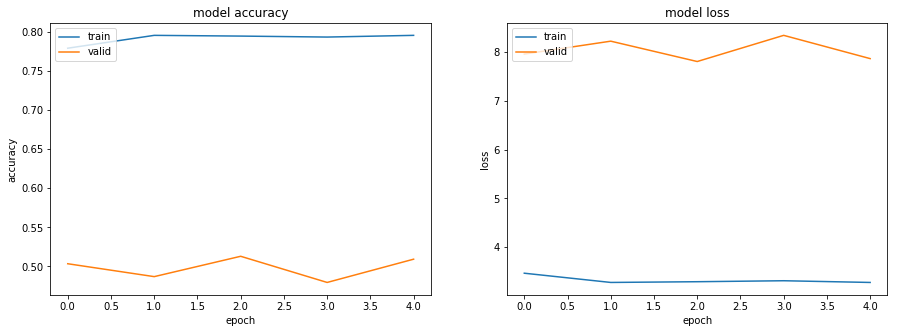

In [22]:
results(hist)

### Deeper CNN with batchnormalization and dropout

In [23]:
model = Sequential()
# layer 1
model.add(Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=(Image_width, Image_height,3)))
model.add(ZeroPadding2D(padding=(1,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# layer 2
model.add(Conv2D(64,(3,3), activation="relu"))
model.add(ZeroPadding2D(padding=(1,1)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2,2)))

# layer 3
model.add(Conv2D(128,(3,3), activation="relu"))
model.add(ZeroPadding2D(padding=(1,1)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2,2)))
# layer 4
model.add(Conv2D(256,(3,3), activation="relu"))
model.add(ZeroPadding2D(padding=(1,1)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2,2)))

# layer 5
model.add(Conv2D(512,(3,3), activation="relu"))
model.add(ZeroPadding2D(padding=(1,1)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2,2)))

# layer 6
model.add(Conv2D(512,(3,3), activation="relu"))
model.add(ZeroPadding2D(padding=(1,1)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2,2)))

# output layer
model.add(Flatten())
model.add(Dense(Number_FC_Neurons))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, fbeta_score])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 300, 300, 32)      0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 300, 300, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 148, 148, 64)      18496     
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 150, 150, 64)      0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 150, 150, 64)      256       
__________

In [24]:
plot_model(model=model, to_file='deeper-cnn.png', show_shapes=True, show_layer_names=True)

In [25]:
hist = model.fit_generator(
    train_generator,
    epochs=Training_Epochs,
    verbose=1,
    steps_per_epoch=num_train_samples // Batch_Size,
    validation_data=validation_generator,
    validation_steps= num_validate_samples // Batch_Size,
    class_weight='auto'
)

Epoch 1/5
101/101 [==============================] - 1124s 11s/step - loss: 0.6427 - acc: 0.6920 - precision: 0.7022 - recall: 0.6720 - fbeta_score: 0.6865 - val_loss: 0.9727 - val_acc: 0.4721 - val_precision: 0.4721 - val_recall: 0.4721 - val_fbeta_score: 0.4721
Epoch 2/5
101/101 [==============================] - 1078s 11s/step - loss: 0.5703 - acc: 0.8039 - precision: 0.8194 - recall: 0.7791 - fbeta_score: 0.7984 - val_loss: 0.7281 - val_acc: 0.4870 - val_precision: 0.4864 - val_recall: 0.4498 - val_fbeta_score: 0.4671
Epoch 3/5
101/101 [==============================] - 1084s 11s/step - loss: 0.5320 - acc: 0.8286 - precision: 0.8368 - recall: 0.8162 - fbeta_score: 0.8262 - val_loss: 0.7238 - val_acc: 0.5056 - val_precision: 0.5056 - val_recall: 0.5056 - val_fbeta_score: 0.5056
Epoch 4/5
101/101 [==============================] - 1178s 12s/step - loss: 0.4949 - acc: 0.8373 - precision: 0.8433 - recall: 0.8289 - fbeta_score: 0.8360 - val_loss: 0.7325 - val_acc: 0.5019 - val_precision

In [26]:
model.evaluate_generator(validation_generator, num_validate_samples)

[0.7335463721437503,
 0.5015449130480533,
 0.5022134139954623,
 0.4457073499029492,
 0.4717569997699825]

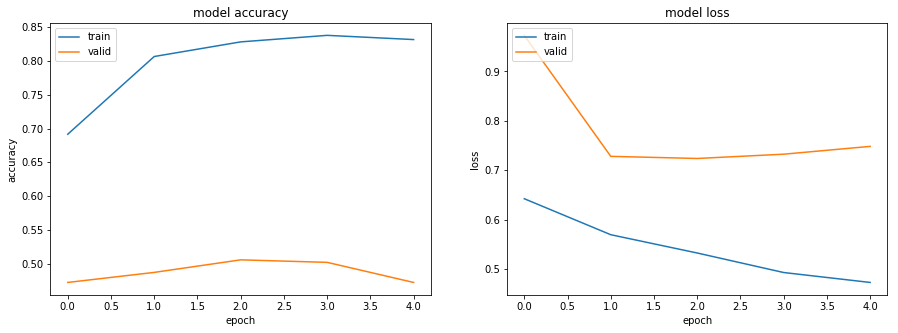

In [27]:
results(hist)